### Building evasion vs. mean time interval : by Bus

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from Utils import TransantiagoConstants
import EvasionBuilder

In [4]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing evasion-ddbb before merging

In [5]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

* Getting evasion by date-bus

In [6]:
f = {'PATENTE':['count'],'INGRESAN':['sum'], 'NO_VALIDAN':['sum']}
summary = evasion_paradero_first.groupby(['FECHA','PATENTE']).agg(f)
summary.columns=['EVASION_COUNT', 'TOTAL_INGRESAN','TOTAL_NO_VALIDAN']
summary.reset_index(inplace=True)

* Computing evasion rate

In [7]:
summary.loc[:,'EVASION_RATE'] = summary.loc[:,'TOTAL_NO_VALIDAN']/summary.loc[:,'TOTAL_INGRESAN']

* Filtering by common_dates

In [8]:
common_dates = TransantiagoConstants.common_dates

In [9]:
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]

In [10]:
common_dates_evasion = summary[summary['FECHA'].isin(common_dates_timestamp)]

* Building complete etapas ddbb.

In [11]:
reduced_etapas = pd.DataFrame()

for date in common_dates:
    base_input_path = 'C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/01_SSH/01_TIMESBYBUS/01_ORIGINAL/'
    file_name = date + '-meanByBus.csv'
    grouped_by_bus = pd.read_csv(base_input_path+file_name, encoding = 'latin-1',sep =";")
    reduced_etapas = pd.concat([reduced_etapas,grouped_by_bus])


* Processing etapas ddbb before merging

In [12]:
del reduced_etapas['Unnamed: 0']
reduced_etapas = reduced_etapas.rename(columns = {'fecha':'FECHA', 'sitio_subida':'PATENTE', 'count': 'ETAPAS_COUNT'})
reduced_etapas['FECHA'] = pd.to_datetime(reduced_etapas.FECHA)
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace("-", "")
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace(" ", "")

In [13]:
reduced_etapas.reset_index(drop=True,inplace=True)

In [14]:
type(reduced_etapas.loc[0,'FECHA'])

pandas._libs.tslib.Timestamp

In [15]:
type(reduced_etapas.loc[0,'fecha_instalacion'])

float

### Merging - Original

In [16]:
evasion_vs_mean = pd.merge(summary,reduced_etapas, on=['FECHA','PATENTE'], how='left')

In [17]:
print('Merged database contains: ' + str(len(evasion_vs_mean.index)) + ' rows.')

Merged database contains: 1183 rows.


* Getting rid of missing values

In [18]:
clean_evasion_vs_mean = evasion_vs_mean[evasion_vs_mean['mean'].notnull()]

In [19]:
print('Merged database with not-null mean time interval contains: ' + str(len(clean_evasion_vs_mean.index)) + ' rows.')

Merged database with not-null mean time interval contains: 496 rows.


* Computing if_turnstile

In [20]:
clean_evasion_vs_mean.loc[:,'fecha_instalacion'] = pd.to_datetime(clean_evasion_vs_mean.loc[:,'fecha_instalacion']) #This line is necessary since type(['fecha_instalacion']) is float. See Out[15]
clean_evasion_vs_mean.loc[:,'SI_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion'].notnull())
clean_evasion_vs_mean.loc[:,'SI_2017_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion']>pd.to_datetime('2017-01-01'))

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [21]:
clean_evasion_vs_mean_no_turnstile = clean_evasion_vs_mean[(clean_evasion_vs_mean['SI_TORNIQUETE']==False) | 
                                                           ((clean_evasion_vs_mean['SI_TORNIQUETE']==True) & (clean_evasion_vs_mean['FECHA']<=clean_evasion_vs_mean['fecha_instalacion']))]

### Plotting - Original

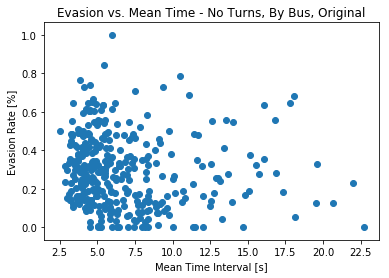

In [22]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(clean_evasion_vs_mean_no_turnstile['mean'],clean_evasion_vs_mean_no_turnstile['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus, Original')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/8_Original_EvasionVsMeanTimeByBus.pdf')

### Analyzing - Original

In [23]:
print('Merged database with not-null mean time interval and no-turnstile contains: ' + str(len(clean_evasion_vs_mean_no_turnstile.index)) + ' rows.')

Merged database with not-null mean time interval and no-turnstile contains: 367 rows.


In [24]:
print('Etapas_count MEAN: ' + str(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].mean()))
print('Etapas_count MIN: ' + str(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].min()))
print('Etapas_count MAX: ' + str(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].max()))

print('Evasion_count MEAN: ' + str(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].mean()))
print('Evasion_count MIN: ' + str(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].min()))
print('Evasion_count MAX: ' + str(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].max()))

Etapas_count MEAN: 275.27792915531336
Etapas_count MIN: 1.0
Etapas_count MAX: 845.0
Evasion_count MEAN: 28.577656675749317
Evasion_count MIN: 3
Evasion_count MAX: 116


* Checking for <strong>outlier 1</strong>

In [26]:
clean_evasion_vs_mean_no_turnstile[clean_evasion_vs_mean_no_turnstile['EVASION_RATE']==1]

FECHA PATENTE  EVASION_COUNT  TOTAL_INGRESAN  TOTAL_NO_VALIDAN  \
530 2017-04-18  CJRZ93             16              21                21   

     EVASION_RATE  ETAPAS_COUNT     sum      mean fecha_instalacion  \
530           1.0         362.0  2161.0  5.969613               NaT   

     SI_TORNIQUETE  SI_2017_TORNIQUETE  
530          False               False

In [42]:
evasion_paradero_first[(evasion_paradero_first['FECHA']==pd.to_datetime('2017-04-18'))&(evasion_paradero_first['PATENTE']=='CJRZ93')]

FECHA  HORA HORA_INICIO  INGRESAN       LUGAR_INICIO  MINUTO  \
34117 2017-04-18    14    14:30:00         5  BILBAO - TOBALABA      30   
34118 2017-04-18    14    14:30:00         0  BILBAO - TOBALABA      36   
34119 2017-04-18    14    14:30:00         1  BILBAO - TOBALABA      40   
34120 2017-04-18    14    14:30:00         0  BILBAO - TOBALABA      44   
34121 2017-04-18    14    14:30:00         2  BILBAO - TOBALABA      45   
34122 2017-04-18    14    14:30:00         0  BILBAO - TOBALABA      52   
34123 2017-04-18    14    14:30:00         6  BILBAO - TOBALABA      55   
34124 2017-04-18    14    14:30:00         2  BILBAO - TOBALABA      57   
34125 2017-04-18    14    14:30:00         1  BILBAO - TOBALABA      59   
34126 2017-04-18    15    14:30:00         2  BILBAO - TOBALABA       0   
34127 2017-04-18    15    14:30:00         0  BILBAO - TOBALABA       1   
34128 2017-04-18    15    14:30:00         1  BILBAO - TOBALABA       2   
34129 2017-04-18    15    14:30:00         0  BILBAO - TOBALABA       3   
34130 2017-04-18    15    14:30:00         1  BILBAO - TOBALABA       5   
34131 2017-04-18    15    14:30:00         0  BILBAO - TOBALABA       6   
34132 2017-04-18    15    14:30:00         0  BILBAO - TOBALABA      11   

       NO_VALIDAN  N_PUERTA PATENTE PUERTAS              TIEMPO TP  \
34117           5         1  CJRZ93       2 2017-04-18 14:30:00  P   
34118           0         1  CJRZ93       2 2017-04-18 14:36:00  P   
34119           1         1  CJRZ93       2 2017-04-18 14:40:00  P   
34120           0         1  CJRZ93       2 2017-04-18 14:44:00  P   
34121           2         1  CJRZ93       2 2017-04-18 14:45:00  P   
34122           0         1  CJRZ93       2 2017-04-18 14:52:00  P   
34123           6         1  CJRZ93       2 2017-04-18 14:55:00  P   
34124           2         1  CJRZ93       2 2017-04-18 14:57:00  P   
34125           1         1  CJRZ93       2 2017-04-18 14:59:00  P   
34126           2         1  CJRZ93       2 2017-04-18 15:00:00  P   
34127           0         1  CJRZ93       2 2017-04-18 15:01:00  P   
34128           1         1  CJRZ93       2 2017-04-18 15:02:00  P   
34129           0         1  CJRZ93       2 2017-04-18 15:03:00  P   
34130           1         1  CJRZ93       2 2017-04-18 15:05:00  P   
34131           0         1  CJRZ93       2 2017-04-18 15:06:00  P   
34132           0         1  CJRZ93       2 2017-04-18 15:11:00  P   

      SERVICIO_USUARIO   UN SERVICIO  
34117              D12  4.0      452  
34118              D12  4.0      452  
34119              D12  4.0      452  
34120              D12  4.0      452  
34121              D12  4.0      452  
34122              D12  4.0      452  
34123              D12  4.0      452  
34124              D12  4.0      452  
34125              D12  4.0      452  
34126              D12  4.0      452  
34127              D12  4.0      452  
34128              D12  4.0      452  
34129              D12  4.0      452  
34130              D12  4.0      452  
34131              D12  4.0      452  
34132              D12  4.0      452

In [43]:
import DailyEtapasBuilder
import re

In [55]:
date = '2017-04-18'
patente = 'CJRZ-93'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 1869904


In [56]:
processed_sorted_df.loc[processed_sorted_df['sitio_subida']==patente,'servicio_subida'].unique()

array(['T402 00I', 'T402 00R', 'T406 00I', 'T406 00R', 'T422 00I'], dtype=object)

* Checking for <strong>outlier 2</strong>

In [58]:
clean_evasion_vs_mean_no_turnstile[clean_evasion_vs_mean_no_turnstile['mean']>22]

FECHA PATENTE  EVASION_COUNT  TOTAL_INGRESAN  TOTAL_NO_VALIDAN  \
916 2017-07-19  CJRZ54              7               6                 0   

     EVASION_RATE  ETAPAS_COUNT     sum       mean fecha_instalacion  \
916           0.0         279.0  6330.0  22.688172               NaT   

     SI_TORNIQUETE  SI_2017_TORNIQUETE  
916          False               False

In [59]:
evasion_paradero_first[(evasion_paradero_first['FECHA']==pd.to_datetime('2017-07-19'))&(evasion_paradero_first['PATENTE']=='CJRZ54')]

FECHA  HORA HORA_INICIO  INGRESAN                    LUGAR_INICIO  \
65581 2017-07-19    20    20:29:00         2  MACUL ALTO / CAMINO DEL CANELO   
65582 2017-07-19    20    20:29:00         1  MACUL ALTO / CAMINO DEL CANELO   
65583 2017-07-19    20    20:29:00         1  MACUL ALTO / CAMINO DEL CANELO   
65584 2017-07-19    20    20:29:00         1  MACUL ALTO / CAMINO DEL CANELO   
65585 2017-07-19    20    20:29:00         0  MACUL ALTO / CAMINO DEL CANELO   
65586 2017-07-19    20    20:29:00         1  MACUL ALTO / CAMINO DEL CANELO   
65587 2017-07-19    20    20:29:00         0  MACUL ALTO / CAMINO DEL CANELO   

       MINUTO  NO_VALIDAN  N_PUERTA PATENTE PUERTAS              TIEMPO TP  \
65581      29           0         1  CJRZ54       2 2017-07-19 20:29:00  P   
65582      36           0         1  CJRZ54       2 2017-07-19 20:36:00  P   
65583      37           0         1  CJRZ54       2 2017-07-19 20:37:00  P   
65584      39           0         1  CJRZ54       2 2017-07-19 20:39:00  P   
65585      40           0         1  CJRZ54       2 2017-07-19 20:40:00  P   
65586      41           0         1  CJRZ54       2 2017-07-19 20:41:00  P   
65587      50           0         1  CJRZ54       2 2017-07-19 20:50:00  P   

      SERVICIO_USUARIO   UN SERVICIO  
65581              D17  4.0      457  
65582              D17  4.0      457  
65583              D17  4.0      457  
65584              D17  4.0      457  
65585              D17  4.0      457  
65586              D17  4.0      457  
65587              D17  4.0      457

In [60]:
date = '2017-07-19'
patente = 'CJRZ-54'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 1637796


In [61]:
processed_sorted_df.loc[processed_sorted_df['sitio_subida']==patente,'servicio_subida'].unique()

array(['T457 03I', 'T443 01I', 'T443 00R', 'T443 00I', 'T457 00R',
       'T457 00I'], dtype=object)

In [64]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)&(processed_sorted_df['mismo_paradero']==True)&(processed_sorted_df['mismo_servicio']==True)]

index          id  nviaje tipo_transporte            t_subida  \
1205721  2082886  3606457763       1             BUS 2017-07-19 06:26:56   
1205723  1645885  2813038238       1             BUS 2017-07-19 06:28:22   
1205727  2335417  4160319259       1             BUS 2017-07-19 06:33:38   
1205731   872958   930173995       1             BUS 2017-07-19 06:41:28   
1205732  1495293  2689561902       1             BUS 2017-07-19 06:41:33   
1205735  2144043  3857310219       1             BUS 2017-07-19 08:33:21   
1205736   937190  1088876644       1             BUS 2017-07-19 08:33:24   
1205737  1704934  3066202475       1             BUS 2017-07-19 08:33:27   
1205738   596261   426667202       1             BUS 2017-07-19 08:33:34   
1205739  2360850  4287312590       1             BUS 2017-07-19 08:35:03   
1205742   567640   424522162       1             BUS 2017-07-19 08:40:35   
1205743  1107593  1729911603       1             BUS 2017-07-19 08:40:38   
1205744   680148   473132626       1             BUS 2017-07-19 08:40:41   
1205746  1938045  3532108660       1             BUS 2017-07-19 08:42:16   
1205747  2189347  3907041902       1             BUS 2017-07-19 08:42:17   
1205748  2012887  3568397086       1             BUS 2017-07-19 08:42:19   
1205749  1724584  3131984606       1             BUS 2017-07-19 08:42:26   
1205750   337531   123927298       1             BUS 2017-07-19 08:42:29   
1205752  2148038  3859814699       1             BUS 2017-07-19 08:43:54   
1205753   674380   472581698       1             BUS 2017-07-19 08:43:56   
1205754   612150   428251394       1             BUS 2017-07-19 08:43:59   
1205755   958587  1213985946       1             BUS 2017-07-19 08:44:01   
1205757  1459772  2554702587       1             BUS 2017-07-19 08:45:33   
1205758   425477   257523282       1             BUS 2017-07-19 08:45:35   
1205760   521083   421059698       1             BUS 2017-07-19 08:46:43   
1205761  1553989  2733458078       1             BUS 2017-07-19 08:46:49   
1205765   717561   477306978       1             BUS 2017-07-19 08:55:35   
1205767   238698    67719540       1             BUS 2017-07-19 08:57:09   
1205768  1939251  3538870382       1             BUS 2017-07-19 08:57:12   
1205769  2056386  3574031598       1             BUS 2017-07-19 08:57:15   
...          ...         ...     ...             ...                 ...   
1206092  1853937  3323155758       4             BUS 2017-07-19 20:00:04   
1206093   908457   933689003       4             BUS 2017-07-19 20:00:17   
1206094   900563   933040379       2             BUS 2017-07-19 20:00:20   
1206095   153247    48088626       2             BUS 2017-07-19 20:00:30   
1206096  1266574  2190094365       3             BUS 2017-07-19 20:00:42   
1206097  2045241  3572202446       2             BUS 2017-07-19 20:00:52   
1206098  1684333  2980835070       4             BUS 2017-07-19 20:00:58   
1206099  1094135  1718555661       2             BUS 2017-07-19 20:01:00   
1206100   710941   475882674       4             BUS 2017-07-19 20:01:02   
1206101  1378743  2500880510       2             BUS 2017-07-19 20:01:05   
1206102  1411746  2511084686       2             BUS 2017-07-19 20:01:07   
1206103   691817   474509378       2             BUS 2017-07-19 20:01:52   
1206111   261780    92734102       5             BUS 2017-07-19 20:57:14   
1206112  1860239  3327210362       2             BUS 2017-07-19 20:57:38   
1206113  2254505  3977736555       3             BUS 2017-07-19 20:57:41   
1206114   182760    52448306       1             BUS 2017-07-19 20:57:54   
1206115  1043750  1504326122       2             BUS 2017-07-19 20:57:58   
1206116   116214    40840866       4             BUS 2017-07-19 20:58:00   
1206117  1480234  2641459534       3             BUS 2017-07-19 20:58:06   
1206118   786552   654371714       6             BUS 2017-07-19 20:58:08   
1206119   906657   933541115       2             BUS 2017-0

* Checking for <strong>outlier 3 and 4</strong>

In [65]:
clean_evasion_vs_mean_no_turnstile[clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT']==1]

FECHA PATENTE  EVASION_COUNT  TOTAL_INGRESAN  TOTAL_NO_VALIDAN  \
724 2017-06-14  BBKB13             11              43                10   
843 2017-07-13  CJRV32              7               9                 0   

     EVASION_RATE  ETAPAS_COUNT   sum  mean fecha_instalacion  SI_TORNIQUETE  \
724      0.232558           1.0  22.0  22.0               NaT          False   
843      0.000000           1.0   8.0   8.0               NaT          False   

     SI_2017_TORNIQUETE  
724               False  
843               False

* <strong>Outlier 3</strong>

In [66]:
evasion_paradero_first[(evasion_paradero_first['FECHA']==pd.to_datetime('2017-06-14'))&(evasion_paradero_first['PATENTE']=='BBKB13')]

FECHA  HORA HORA_INICIO  INGRESAN       LUGAR_INICIO  MINUTO  \
61106 2017-06-14     7    07:02:00         8  SAN JOSE DE MAIPO       2   
61107 2017-06-14     7    07:02:00         5  SAN JOSE DE MAIPO       3   
61108 2017-06-14     7    07:02:00         1  SAN JOSE DE MAIPO       6   
61109 2017-06-14     7    07:02:00         3  SAN JOSE DE MAIPO       8   
61110 2017-06-14     7    07:02:00         7  SAN JOSE DE MAIPO       9   
61111 2017-06-14     7    07:02:00         8  SAN JOSE DE MAIPO      10   
61112 2017-06-14     7    07:02:00         5  SAN JOSE DE MAIPO      12   
61113 2017-06-14     7    07:02:00         1  SAN JOSE DE MAIPO      19   
61114 2017-06-14     7    07:02:00         0  SAN JOSE DE MAIPO      30   
93199 2017-06-14     7    07:02:00         2  SAN JOSE DE MAIPO      13   
93200 2017-06-14     7    07:02:00         3  SAN JOSE DE MAIPO      14   

       NO_VALIDAN  N_PUERTA PATENTE PUERTAS              TIEMPO TP  \
61106           0         1  BBKB13       2 2017-06-14 07:02:00  P   
61107           1         1  BBKB13       2 2017-06-14 07:03:00  P   
61108           0         1  BBKB13       2 2017-06-14 07:06:00  P   
61109           1         1  BBKB13       2 2017-06-14 07:08:00  P   
61110           1         1  BBKB13       2 2017-06-14 07:09:00  P   
61111           2         1  BBKB13       2 2017-06-14 07:10:00  P   
61112           2         1  BBKB13       2 2017-06-14 07:12:00  P   
61113           0         1  BBKB13       2 2017-06-14 07:19:00  P   
61114           0         1  BBKB13       2 2017-06-14 07:30:00  P   
93199           0         1  BBKB13       2 2017-06-14 07:13:00  P   
93200           3         1  BBKB13       2 2017-06-14 07:14:00  P   

      SERVICIO_USUARIO   UN SERVICIO  
61106              F11  7.0      F11  
61107              F11  7.0      F11  
61108              F11  7.0      F11  
61109              F11  7.0      F11  
61110              F11  7.0      F11  
61111              F11  7.0      F11  
61112              F11  7.0      F11  
61113              F11  7.0      F11  
61114              F11  7.0      F11  
93199              F11  7.0      F11  
93200              F11  7.0      F11

In [68]:
date = '2017-06-14'
patente = 'BBKB-13'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 517700


In [70]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)]

index          id  nviaje tipo_transporte            t_subida  \
162  439020  2349795466       1             BUS 2017-06-14 21:43:09   
163   63592    47993730       2             BUS 2017-06-14 21:43:31   

    servicio_subida      par_subida sitio_subida fecha_instalacion  \
162         F11 00R  E-34-270-NS-70      BBKB-13               NaT   
163         F11 00R  E-34-270-NS-70      BBKB-13               NaT   

     mismo_paradero  misma_patente  mismo_servicio diferencia_tiempo  \
162           False          False           False               NaT   
163            True           True            True          00:00:22   

     diferencia_tiempo_secs  si_torniquete  si_2017_torniquete  
162                     NaN          False               False  
163                    22.0          False               False

In [71]:
len(processed_sorted_df.index)

803771

* Outlier 4

In [67]:
evasion_paradero_first[(evasion_paradero_first['FECHA']==pd.to_datetime('2017-07-13'))&(evasion_paradero_first['PATENTE']=='CJRV32')]

FECHA  HORA HORA_INICIO  INGRESAN LUGAR_INICIO  MINUTO  NO_VALIDAN  \
63475 2017-07-13    17    17:05:00         2     TOBALABA       9           0   
63476 2017-07-13    17    17:05:00         1     TOBALABA      20           0   
63477 2017-07-13    17    17:05:00         0     TOBALABA      25           0   
63478 2017-07-13    17    17:05:00         2     TOBALABA      28           0   
63479 2017-07-13    17    17:05:00         3     TOBALABA      30           0   
63480 2017-07-13    17    17:05:00         1     TOBALABA      36           0   
63481 2017-07-13    17    17:05:00         0     TOBALABA      41           0   

       N_PUERTA PATENTE PUERTAS              TIEMPO TP SERVICIO_USUARIO   UN  \
63475         1  CJRV32       2 2017-07-13 17:09:00  P              D16  4.0   
63476         1  CJRV32       2 2017-07-13 17:20:00  P              D16  4.0   
63477         1  CJRV32       2 2017-07-13 17:25:00  P              D16  4.0   
63478         1  CJRV32       2 2017-07-13 17:28:00  P              D16  4.0   
63479         1  CJRV32       2 2017-07-13 17:30:00  P              D16  4.0   
63480         1  CJRV32       2 2017-07-13 17:36:00  P              D16  4.0   
63481         1  CJRV32       2 2017-07-13 17:41:00  P              D16  4.0   

      SERVICIO  
63475      456  
63476      456  
63477      456  
63478      456  
63479      456  
63480      456  
63481      456

In [72]:
date = '2017-07-13'
patente = 'CJRV-32'

etapas_builder = DailyEtapasBuilder.RunSilentlyDailyEtapasBuilderClass(date)
etapas_builder.loadSimplifiedEtapas()
etapas_builder.mergeTurnstileData()
etapas_builder.cleanDataFrame()
etapas_builder.sortDataFrame()
etapas_builder.postProcessingSortedDataFrame()
processed_sorted_df = etapas_builder.etapas_df

Not found in turnstile database: 1560500


In [73]:
processed_sorted_df[(processed_sorted_df['sitio_subida']==patente)]

index          id  nviaje tipo_transporte            t_subida  \
1022920   850111   931460699       2             BUS 2017-07-13 18:41:22   
1022921  1890053  3557200875       1             BUS 2017-07-13 18:41:30   

        servicio_subida      par_subida sitio_subida fecha_instalacion  \
1022920     T420 E0 00I  T-19-170-NS-30      CJRV-32               NaT   
1022921     T420 E0 00I  T-19-170-NS-30      CJRV-32               NaT   

         mismo_paradero  misma_patente  mismo_servicio diferencia_tiempo  \
1022920           False          False           False               NaT   
1022921            True           True            True          00:00:08   

         diferencia_tiempo_secs  si_torniquete  si_2017_torniquete  
1022920                     NaN          False               False  
1022921                     8.0          False               False

In [74]:
len(processed_sorted_df.index)

2222618

In [76]:
processed_sorted_df.loc[(processed_sorted_df['servicio_subida'].str.contains('456')),'sitio_subida'].unique()

array(['CJRS-44', 'CJRS-80', 'CJRT-95', 'CJRV-15', 'CJRV-24', 'CJRV-30',
       'CJRV-35', 'CJRV-65', 'CJRV-82', 'CJRW-35', 'CJRW-98', 'CJRX-84',
       'CJRZ-11', 'CJRZ-52', 'CJRZ-54'], dtype=object)

# Temporarily closed